# INF674 S8: Wikipedia PageRank

## Céline Comte & Fabien Mathieu

## 2017 - 2018

You learned the theoretical basis of PageRank in previous session. Time to get your hands dirty.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 1. Reminders

## Wikipedia Dataset

We remind that we use French and English crawls of Wikipedia made in 2013 and available on http://webgraph.di.unimi.it/. The graphs have been *cleaned*: only links from one article to another article are kept.

Two main differences with the DBLP database:
- The graphs are *oriented*: a link from $i$ to $j$ does not mean there is a link from $j$ to $i$.
- The graphs are bigger. You need to be smart on the way you write your code, both from theoretical and practical points of view. 

The French crawl is made of three files stored in the file ``frwiki-2013.zip``:
- **frwiki-2013.ids** contains the article titles (one per line, $ n $ lines in total). By convention, each article is associated to its line number (from $ 0 $ to $ n-1 $).
- **frwiki-2013.adja** contains the adjacency list of the graph: line $ i $ (from $ 0 $ to $ n-1 $) contains, in plain ASCII, the numbers of the articles that are linked by $ i $. 
- **frwiki-2013-t.adja** contains the adjacency list of the transposed graph: line $ i $ (from $ 0 $ to $ n-1 $) contains the numbers of the articles that have a link to $ i $.

The English crawl is provided in a similar way, with the prefix **enwiki-2013** instead of **frwiki-2013**. Note that it is roughly three times bigger than the French crawl. Feel free to use the dataset(s) you want, but starting with French is strongly recommended (a full PageRank computation can take a few minutes on a slow machine).

This practical assumes the datasets are stored in **../Datasets/** relatively to your working directory. If it not the case, just change the following cell accordingly.

In [2]:
directory = "../Datasets/"

## Caching results

It can be a burden to parse again and again the same datas from ASCII files and convert them into a proper format. The following function will be used to automatically save the variables you extract from the dataset to a more numpy-friendly format. Currently comes in two flavors:
- using **compress = False** will store variables in uncompressed *npy* files. Very fast to read (especially if you have a SSD drive), but storage costly.
- using **compress = True** will store variables in compressed *npy* files. Storage efficient, but CPU costly. Can be interesting in case you have a mechanic hard drive, ultra-fast CPU or storage shortage.

Also note the presence of a *rebuild* flag to force the variable to be recomputed.

Thanks to Pierre-Antoine (ACN 2017-2018) for hinting the approach (even if his solution based on *npz* seemed to only work on his laptop for some reason, so I had to try something else).

**Remark:** compared to previous versions, the code has slightly been updated to be able to pass the transposition through a ``transpose`` boolean. That been said, your old ``gz`` files from previous practicals should still work, so you **do not** have to recompute them.

In [3]:
import zipfile
import gzip
import codecs

def use_cache(builder, prefix="frwiki-2013", variable = "size", transpose=False, rebuild=False, compress=False):            
    if transpose:
        t = "-t"
    else:
        t = ""
    try:
        if rebuild:
            raise ValueError('Value needs to be rebuilt')
        if compress:
            with gzip.GzipFile(directory+prefix+t+"-"+variable+".npy.gz", "r") as f:
                return np.load(f)
        else:
            return np.load(directory+prefix+t+"-"+variable+".npy")
    except:
        data = builder(prefix, transpose=transpose)
        if compress:
            with gzip.GzipFile(directory+prefix+t+"-"+variable+".npy.gz", "w") as f:
                np.save(f, data)
        else:
            np.save(directory+prefix+t+"-"+variable, data)
        return data
# Set default behavior
compress = True

Most of the core functions below have the following behavior: first they try to load the results from an npy file if one exists, otherwise they parse the dataset to extract the information and save it in an npy file for the next use. This approach avoids re-doing the same work over and over again.

You are strongly encouraged to use the same tactic for saving your PageRank computations.

## Size and degree

The following function gives the number of nodes $n$ and the total number of *oriented edges* $m$ of the graph.

In [4]:
def build_size(prefix = "frwiki-2013", transpose=False):
    n = 0
    m = 0
    with zipfile.ZipFile(directory+prefix+".zip") as myzip:
        with myzip.open(prefix+".adja") as f:
            for line in f:
                n += 1
                m += len([int(s) for s in line.split()])
    size = array([n, m])
    return size

def get_size(prefix = "frwiki-2013", rebuild = False):
    return use_cache(build_size, prefix, variable = "size", rebuild = rebuild, compress = compress)

Let us run it once to create the value if you didn't keep it from previous practicals.

In [5]:
prefix = "frwiki-2013"
n, m = get_size(prefix)
print("Number of nodes in %s: %s" % (prefix, n))
print("Number of edges in %s: %s" % (prefix, m//2))

Number of nodes in frwiki-2013: 1352053
Number of edges in frwiki-2013: 17189215


Now, the function for extracting degree. Remind that in oriented graphs, you have to distinguish between indegree and outdegree (cf the *Power Laws* practical).

In [6]:
def build_degree(prefix = "frwiki-2013", transpose=False):
    if transpose:
        t = "-t"
    else:
        t = ""
    n, m = get_size(prefix)
    degree = zeros(n, dtype = int)
    i = 0
    with zipfile.ZipFile(directory+prefix+".zip") as myzip:
        with myzip.open(prefix+t+".adja") as f:
            for line in f:
                degree[i] = len([int(s) for s in line.split()])
                i += 1
    return degree

def get_degree(prefix = "frwiki-2013", transpose=False, rebuild = False):
    return use_cache(build_degree, prefix, variable = "degree", transpose=transpose, rebuild = rebuild, compress = compress)

Let us parse the degrees.

In [7]:
out_deg = get_degree(prefix)
in_deg = get_degree(prefix, transpose = True)

out_dist = bincount(out_deg)
in_dist = bincount(in_deg)

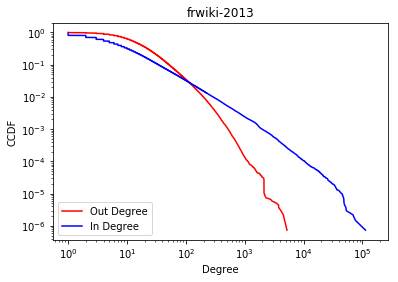

In [8]:
loglog(sort(out_deg), 1-linspace(0,1,len(out_deg)), 'r', label = "Out Degree")
loglog(sort(in_deg), 1-linspace(0,1,len(in_deg)), 'b', label = "In Degree")
xlabel("Degree")
ylabel("CCDF")
title(prefix)
legend(loc = 3)
show()

## Adjacency List

In order to avoid crippling your RAM with a full matrix, we'll use the same format as the one introduced in previous practicals.

In [9]:
def build_adjacency(prefix="frwiki-2013", transpose=False):
    if transpose:
        t = "-t"
    else:
        t = ""
    n, m = get_size(prefix)
    A = zeros(n + m + 1, dtype=int)
    A[0] = n + 1  # Don't forget the +1!!!
    with zipfile.ZipFile(directory + prefix + ".zip") as myzip:
        with myzip.open(prefix + t + ".adja") as f:
            i = 0
            for line in f:
                neighbors = array(line.split(), dtype=int)
                A[i + 1] = A[i] + len(neighbors)
                A[A[i]:A[i + 1]] = neighbors
                i += 1
    return A


def get_adjacency(prefix="frwiki-2013", transpose=False, rebuild=False):
    return use_cache(
        build_adjacency,
        prefix,
        variable="adjacency",
        transpose=transpose,
        rebuild=rebuild,
        compress=compress)

The result, *A*, is a numpy array of integers of size $n+m+1$, organized as follows:
- The $n+1$ first values are indexes
- The $m$ last values are destinations
- The neighbors of a node $i$ are stored in A[A[i]:A[i+1]]

In [10]:
A = get_adjacency(prefix)

## Index / Name conversion

The following cell extracts the names.

In [11]:
def build_ids(prefix="dblp", transpose=False):
    n, m = get_size(prefix)
    delimiter = zeros(n + 1, dtype=int)
    text = ""
    with zipfile.ZipFile(directory + prefix + ".zip") as myzip:
        with myzip.open(prefix + ".ids") as f:
            i = 0
            for line in codecs.iterdecode(f, 'utf8'):
                delimiter[i + 1] = delimiter[i] + len(line) - 1
                text += line[0:-1]
                i += 1
    return [delimiter, text]


def get_ids(prefix="dblp", rebuild=False):
    return use_cache(
        build_ids, prefix, variable="ids", rebuild=rebuild, compress=compress)

Then the traditional **index2name** translator (remark: name2index will not be required for this practical).

In [12]:
def index2name(index, prefix = "dblp", delimiter = None, text = None):
    if delimiter is None:
        delimiter, text = get_ids(prefix)
    return text[delimiter[index]:delimiter[index+1]]

In [13]:
index2name(1231231, prefix)

'Acidocétose'

# 2.  Computing Rankings 

## Question 1 

Propose a function that takes for input a vector $ P $ of size $ n $, an integer $ k>0 $ (default to $ k=10 $) and a prefix for a dataset of size $n$. The function should print the titles of the $ k $ articles with highest value according to $ P $. Test your function by displaying the names of the $ k $ articles with highest indegree, then the name of the $k$ articles with highest outdegree.

In terms of ranking, which seems to be the more relevant: indegree or outdegree? (remember to try and justify your answer, please)

**Answer:** 

## Question 2

Let $A$ the transition matrix seen in course, defined by
$$A[i,j] = \frac{1}{outdegree(i)}\text{ if }i\rightarrow j, 0\text{ otherwise.}$$

Compute a PageRank based on the following iteration: do $P_{n+1} = \alpha P_n A + (1-\alpha)Z$ until $||P_{n+1}-P_n||_1\leq \epsilon ||P_n||_1$.

You will probably use a $P_{old}$ vector to store previous iteration and a $P_{new}$ vector to store the new one.

You will monitor (e.g. print) the time per iteration and the total time (you can use ``import time``, ``time.clock()``).

Comment the results (top $k$).

Recommended values: $\alpha = 0.7$, $Z = [1,\ldots, 1]/n$, $\epsilon=0.1$ (you may go down to $0.01$ if you have a fast computer).

**Answer:**

In [14]:
import time

# 3. Optimization

The algorithm above may be a little bit slow. Let's do some tuning. You will learn to speed up your algorithm by mixing theoretical and practical considerations, and it will allow you to play more with the last part. Don't forget to compare your results to the previous question to verify that you did not break anything.

It is OK if the name of your PageRank function remains the same thorough all questions.

## Question 1

Playing with $ \alpha $ and with the precision may help to speed up the process. Is it a good idea?

**Answer:** 

## Question 2

Try to downsize the time per iteration. How many divisions do you perform per iteration? If it is $m$, you should be able to cut that to $ n $ (with better memory access too). Beware of leaves! How does the time per iteration evolve? Also note that for some obscure reasons, multiplications are slightly faster than divisions in Python.

**Answer:** 

## Question 3

Downsize the number of iterations. Instead of using a new vector for $PA$, try to do the update in place. How does the number of iterations evolve (note: you will probably not notice a difference if $\epsilon$ is too large, you should try $\epsilon=0.01$)? For the record, this is called the Gauss-Seidel method, and one can prove that it enhances convergence.

**Answer:** 

## Question 4

For practical use, the ranking matters but not the actual importance values. Replace the stopping condition by *last iteration did not change the ranking of the top $ k $ articles* (e.g. with $ k = 20 $). If you did the previous optimization, you probably do not need to store two distinct values of $P$.

**Answer:** 

## Question 5 (bonus)

Look at the following code. Can you tell what it does? Compare it with the previous PageRank function in terms of results and efficiency (time and memory).

In [15]:
def diteration(prefix = "frwiki-2013", alpha = 0.75, k = 20):
    # Setup
    n, m = get_size(prefix)
    H = zeros(n)
    F = ones(n)
    A = get_adjacency(prefix)
    total_time = time.clock()
    ind = argsort(H)[-1:-k-1:-1]
    stable = False
    iter = 0
    # Outer loop
    while not(stable):
        iter += 1
        iter_time = time.clock()
        ind_old = ind
        # Inner loop
        for i in nditer(nonzero(F>alpha*mean(F))):
            outnodes = A[A[i]:A[i+1]]
            H[i] += F[i]
            if outnodes.size:
                F[outnodes] += alpha*F[i]/outnodes.size
            F[i]=0
        ind = argsort(H)[-1:-k-1:-1]
        stable = (ind_old == ind).all()
        print("Iteration {}: time ".format(iter)+str(time.clock()-iter_time))
    print("Total time: "+str(time.clock()-total_time)+" ({} iterations)".format(iter))
    return H 

**Answer:** 

## Question 6

Instead of using $ [1,\ldots, 1] $ as initial value, why not use a previously saved computation? Interest: if you already computed a PageRank for a small $ k $ and want better precision (larger $ k $), you do not need to restart from scratch. For the record, this is how one updates PageRank of Web graphs when a fresh crawl is made: one uses the old PageRank as an educated guess for the new PageRank.

**Answer:** 

## Question 7 (bonus)

Discuss what should be done for computing PageRank on a much larger graph (hundred of millions, or even billions of nodes).

**Answer:** 

# 4. Customization

The only semantic information you have about the datasets is the name of the articles. Is it enough to get pertinent pages relatively to a given subject?

**Remark:** It is strongly recommended (but not mandatory) that you work on the Optimization questions *before* starting this part.

## Question 1

The algorithm uses a uniform vector $ Z = [1, \ldots, 1] $. Modify it to take an additional argument **s** (a string) such that  $ Z[i] $ is  1 if **s** is in the title of $ i $, 0 otherwise. Save your $ Z $ and $ P $ in files with **s** in the name. Test your algorithm on some values of **s** and comment. Possible inputs (don't hesitate to propose your owns; some inputs work better than others):
- for **frwiki-2013**: **film**, **biologie**, **physique**, **philosoph**, ... 
- for **enwiki-2013**: **movie**, **biology**, **physic**, **philosoph**, ... 
As usual, comment the results!

**Answer:** 

## Question 2

Using a non-uniform $ Z $ will create a bias in favor of the pages that contain **s** in the title. A simple workaround consists in ranking according to $ P-(1-\alpha)Z $ instead of $ P $. $ P-(1-\alpha)Z $ is called the residual PageRank.

Explain what is the meaning of $P-(1-\alpha)Z$ and modify your algorithm to output that instead of $P$.

**Remark:** Depending on the optimizations you made, it may not be $P-(1-\alpha)Z$ that you have to consider (if you don't understand this remark, it means you can probably safely ignore it).

**Answer:** 

## Question 3 (bonus)

Adapt the algorithm from *3. Optimization Question 5* to compute the residual PageRank. Discuss the differences.

Remark: the optimization from Question 3.6 is not easy to make on the algorithm from 3.5. Don't try to implement it.

**Answer:** 

## Question 4 (bonus)

Try the other dataset (English / French).

**Answer:** 